In [209]:
import librosa
from annotations import Annotations
import matplotlib.pyplot as plt
import soundfile as sf
from units import TimeUnit
from scipy import signal,ndimage
from sklearn.neighbors import KNeighborsClassifier



import numpy as np

In [210]:
training = Annotations("C:\\Users\\plaf\\Music\\ALAN_training\\annotations\\training\\", "raven")

In [211]:
training.load()

Reading tables: [--------------------------------------->] 100%


In [212]:
training.map_labels("c:\\Users\\plaf\\Music\\ALAN_training\\annotations\\labels.json")


Changing labels: [--------------------------------------->] 100%


In [213]:
training.load_audio_paths("c:\\Users\\plaf\\Music\\ALAN_training\\audiofiles")

Retrieving audio paths: [--------------------------------------->] 100%


## Load labels

In [214]:
labels = []
audiofile_ids = []
audiofile_paths = []
segments = []
classes = []

for f_i, af_wrap in enumerate(training.audio_files.values()):
    seg_sorted = sorted(af_wrap.segments, key=lambda seg: seg.tstart)
    audiofile_paths.append(af_wrap.audio_file.path)
    for i, seg in enumerate(seg_sorted):
        try:
            l_i = labels.index(seg.label)
        except ValueError as e:
            l_i = len(labels)
            labels.append(seg.label)
        classes.append(l_i)
        audiofile_ids.append(f_i)
        segments.append(seg)

classes = np.array(classes)
audiofile_ids = np.array(audiofile_ids)
n_samples = len(segments)



In [260]:
pad_s = 3
intensities = {"mean": [], "std": [], "mean_padded": []}
intensities_per_af = [[] for _ in audiofile_paths]
for i, (seg, f_i) in enumerate(zip(segments, audiofile_ids)):
    audio_path = audiofile_paths[f_i]
    s = seg
    y, sr = librosa.load(audio_path, sr=None, offset=s.tstart.s, duration=s.dur.s)

    S = librosa.stft(y, n_fft=2048)
    spec = librosa.amplitude_to_db(np.abs(S))
    intensities["std"].append(np.std(spec))
    intensities["mean_padded"].append(np.mean(spec))
    # intensities["argmax"].append(np.mean(np.argmax(spec, axis=1)))
    s = seg.centered_pad_to(TimeUnit(pad_s))
    # s = seg
    y, sr = librosa.load(audio_path, sr=None, offset=s.tstart.s, duration=s.dur.s)

    S = librosa.stft(y, n_fft=2048)
    spec = librosa.amplitude_to_db(np.abs(S))
    # intensities["std"].append(np.std(spec))
    intensities["mean_padded"].append(np.mean(spec))
    # intensities["argmax"].append(np.mean(np.argmax(spec, axis=1)))
    
for k in intensities.keys():
    intensities[k] = np.array(intensities[k])


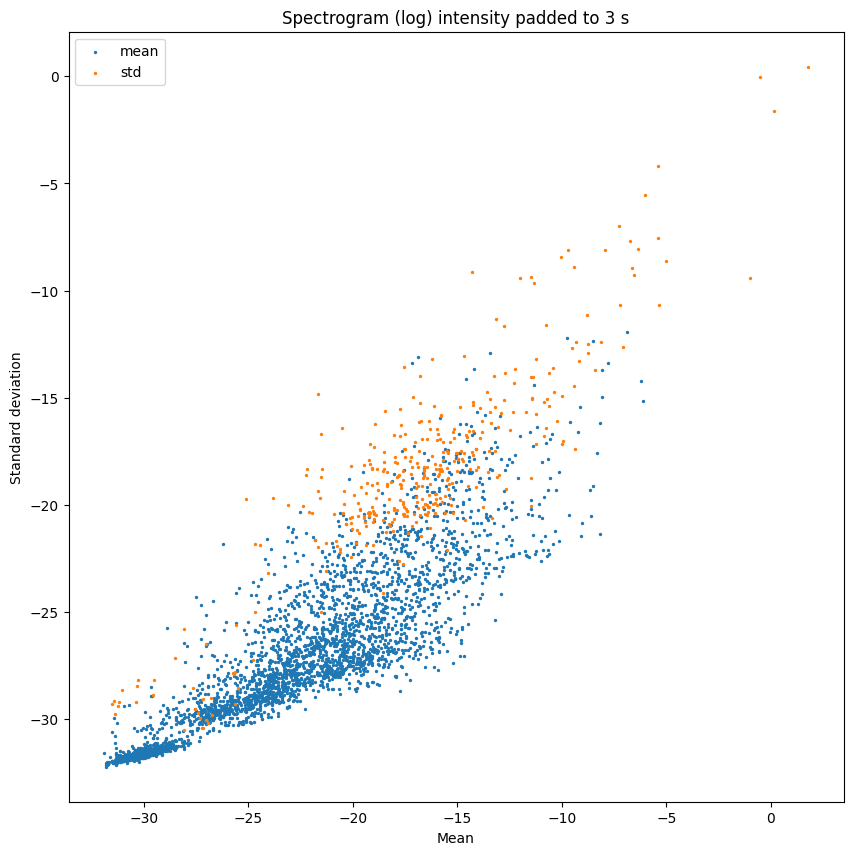

In [262]:
fig = plt.figure(figsize=(10,10))

for i_l, label in enumerate(labels):
    plt.scatter(intensities["mean"][classes == i_l], intensities["mean_padded"][classes == i_l], label=label, s=2)
plt.title(f"Spectrogram (log) intensity padded to {pad_s} s")
plt.xlabel("Mean")
plt.ylabel("Standard deviation")
plt.legend()
# plt.xlim([0,1])
# plt.ylim([0,2.5])
plt.show()

In [217]:
distances = []
n_neighbors = 20
for i, (f_i, seg) in enumerate(zip(audiofile_ids, segments)):
    this_file = audiofile_ids == f_i
    istart = np.argmax(this_file)
    iend = len(audiofile_ids) - np.argmax(this_file[::-1])
    neighbors_dist = [np.abs(segments[j].tstart - segments[j-1].tstart) for j in range(max(istart + 1, i-n_neighbors), min(iend, i+n_neighbors))]
    mean_distance = np.mean(neighbors_dist)
    distances.append(mean_distance)

distances = np.array(distances)

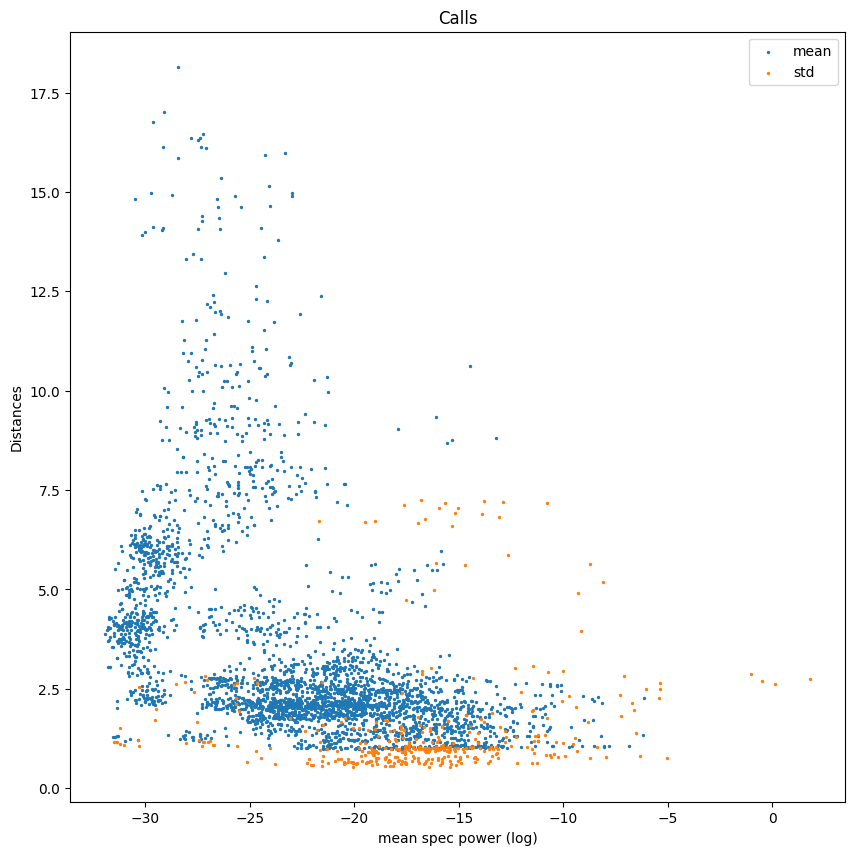

In [265]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
x = "mean"
for i_l, label in enumerate(labels):
    ax.scatter(intensities[x][classes == i_l], distances[classes == i_l], label=label, s=2)
plt.title("Calls")
plt.xlabel(f"{x} spec power (log)")
plt.ylabel("Distances")
plt.legend()
# plt.xlim([0,1])
# plt.ylim([0,2.5])
plt.show()

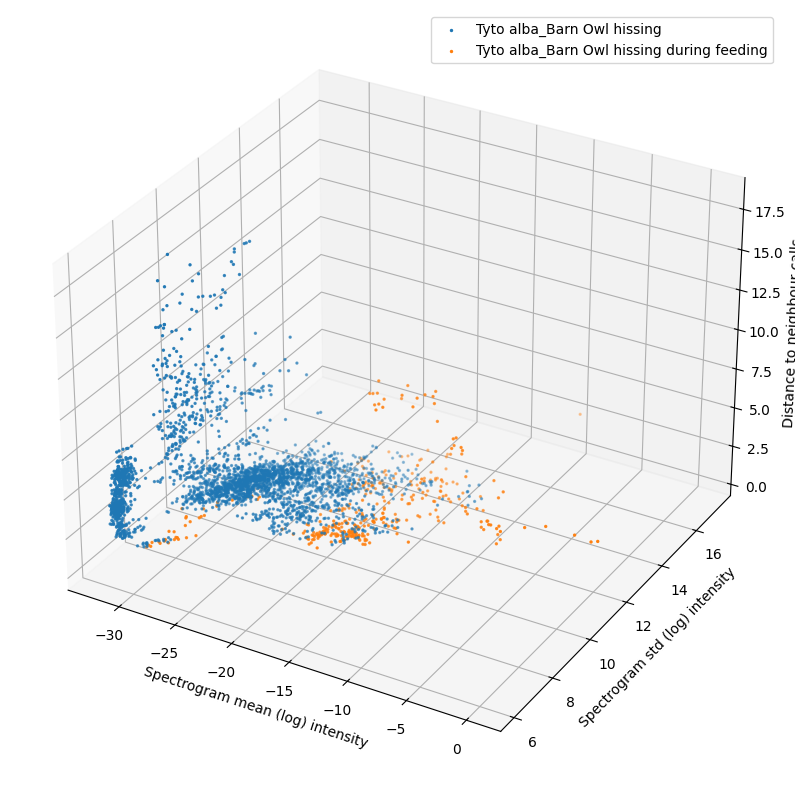

In [219]:
i = 0
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
x = "mean"
y = "std"
for i_l, label in enumerate(labels):
    ax.scatter(intensities[x][classes == i_l], intensities[y][classes == i_l], distances[classes == i_l], label=label, s=2)
    i+=1
plt.xlabel(f"Spectrogram {x} (log) intensity")
plt.ylabel(f"Spectrogram {y} (log) intensity")
ax.set_zlabel("Distance to neighbour calls")
plt.legend()
# plt.xlim([0,1])
# plt.ylim([0,2.5])
plt.show()

In [220]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from joblib import dump, load



0.7698782602744645 0.012496747628055126
RF score 0.9682165979988229
MPL score 0.9364331959976456
GNB score 0.8875809299587993
18 36 1699
Precision: 0.898876404494382
Recall: 0.8163265306122449


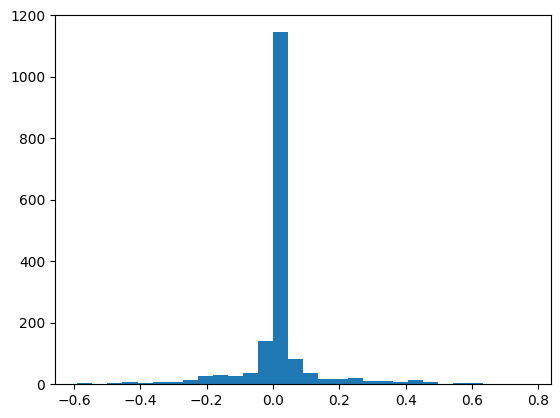

In [221]:

labels = list(intensities.keys())
X = np.stack([
    intensities["mean"],
    intensities["std"],
    distances
], axis=1)
y = classes

prev_n = 0


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=42)

# class_weight = {}
# for i, (n, l) in enumerate(zip(n_segs, labels)):
#     class_weight[i] = n/tot_n_segs
#     if l == "Tyto alba_Barn Owl hissing during feeding":
#         class_weight[i] *= 10

# print(class_weight)
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
gnb = GaussianNB()
mpl = MLPClassifier(max_iter=500)
rf.fit(X_train, y_train)
gnb.fit(X_train, y_train)
mpl.fit(X_train, y_train)
y_pred = rf.predict(X_test)

y_pred_prob_rf = rf.predict_proba(X_test)
y_pred_prob_gnb = gnb.predict_proba(X_test)
y_pred_prob_mpl = mpl.predict_proba(X_test)

prob_diff = y_pred_prob_rf[:, 0] - y_pred_prob_mpl[:, 0]

print(np.max(prob_diff), np.mean(prob_diff))

plt.hist(prob_diff, bins=30)

diff = y_test - y_pred

fp = diff == -1
fn = diff == 1
t = (diff == 0)
tp = t & y_test == 1
tn = t & y_test == 0

fp_n = np.sum(fp)
fn_n = np.sum(fn)
t_n = np.sum(t)
tp_n = np.sum(tp)
tn_n = np.sum(tn)

print("RF score", rf.score(X_test, y_test))
print("MPL score", mpl.score(X_test, y_test))
print("GNB score", gnb.score(X_test, y_test))
print(fp_n, fn_n, len(y_test))
print("Precision:", tp_n/(tp_n + fp_n))
print("Recall:", tp_n/(tp_n + fn_n))

In [222]:
dump(rf, "..\\Documents\\rf.joblib")


['..\\Documents\\rf.joblib']

In [223]:
tstarts = np.array([s.tstart for s in segments])


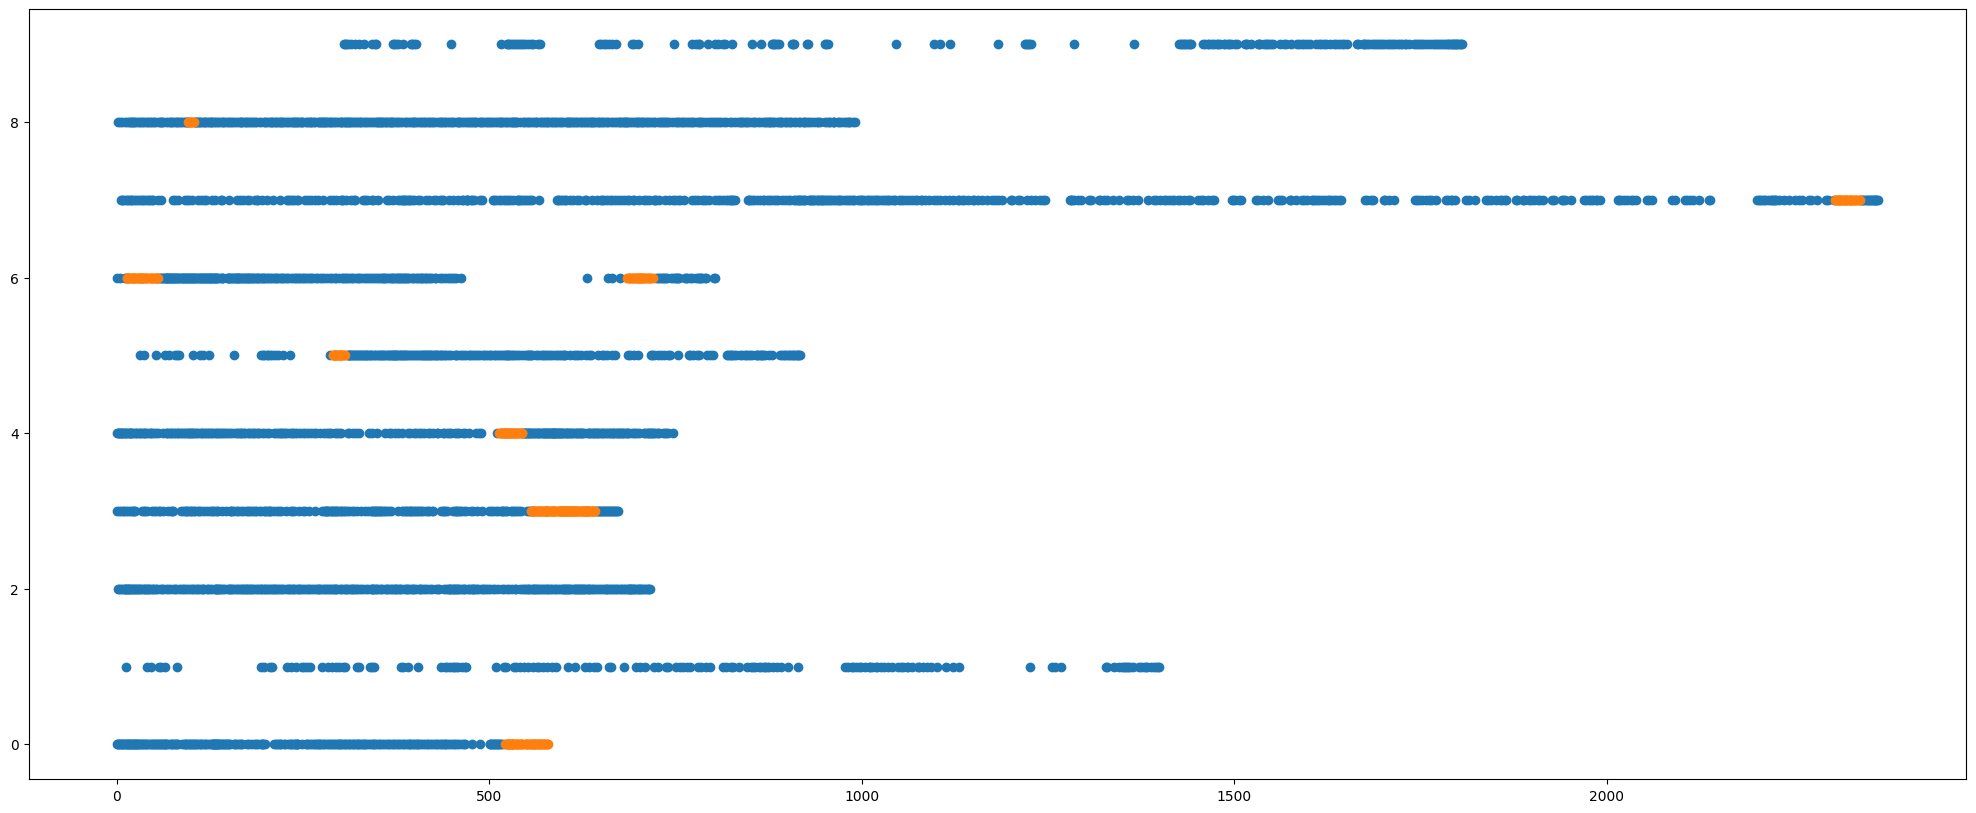

In [224]:
colors_list = ["tab:blue", "tab:orange"]
fig = plt.figure(figsize=(25,10))


for i_l, label in enumerate(labels):
    plt.scatter(tstarts[classes == i_l], audiofile_ids[classes == i_l], c=colors_list[i_l], label=label)

plt.show()

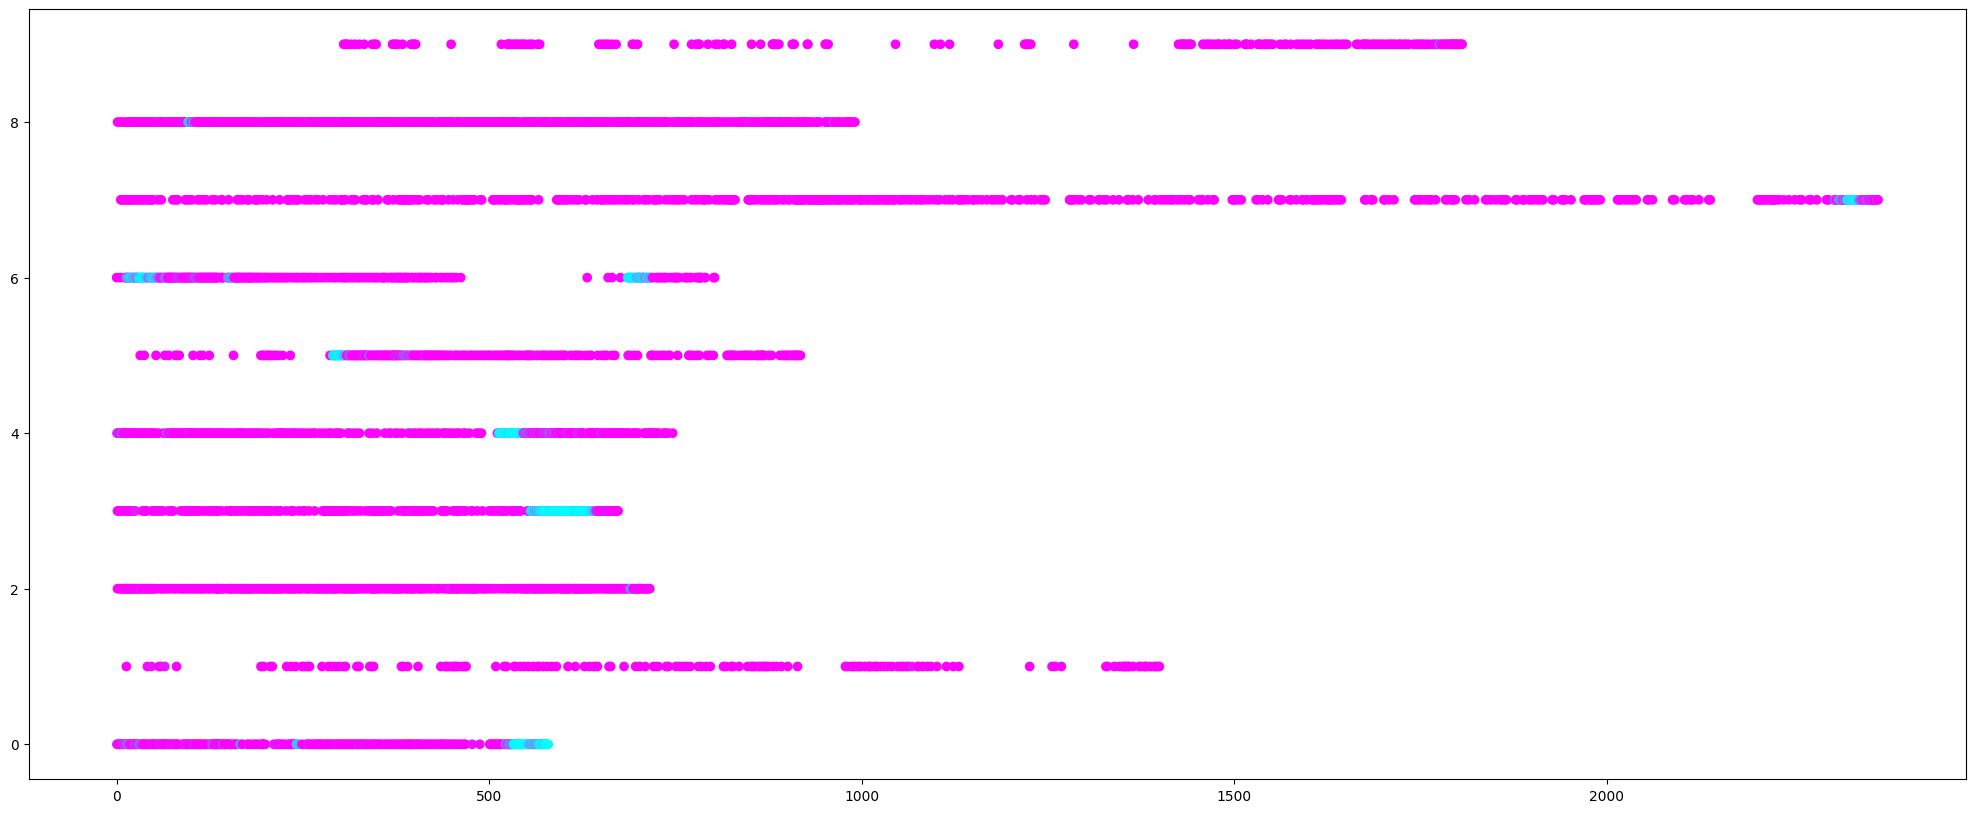

In [225]:
fig = plt.figure(figsize=(25,10))

y_pred_prob = rf.predict_proba(X)
plt.scatter(tstarts, audiofile_ids, c=y_pred_prob[:,0], cmap="cool", label=label)

plt.show()

# Load test


In [226]:
test = Annotations("C:\\Users\\plaf\\Music\\ALAN_training\\annotations\\validation\\", "raven")

In [227]:
test.load()

Reading tables: [--------------------------------------->] 100%


In [228]:
test.map_labels("c:\\Users\\plaf\\Music\\ALAN_training\\annotations\\labels.json")


Changing labels: [--------------------------------------->] 100%


In [229]:
test.load_audio_paths("c:\\Users\\plaf\\Music\\ALAN_training\\audiofiles")

Retrieving audio paths: [--------------------------------------->] 100%


## Load segments

In [230]:
labels = []
test_audiofile_ids = []
test_audiofile_paths = []
test_segments = []
test_classes = []

for f_i, af_wrap in enumerate(test.audio_files.values()):
    seg_sorted = sorted(af_wrap.segments, key=lambda seg: seg.tstart)
    test_audiofile_paths.append(af_wrap.audio_file.path)
    for i, seg in enumerate(seg_sorted):
        try:
            l_i = labels.index(seg.label)
        except ValueError as e:
            l_i = len(labels)
            labels.append(seg.label)
        test_classes.append(l_i)
        test_audiofile_ids.append(f_i)
        test_segments.append(seg)

test_classes = np.array(test_classes)
test_audiofile_ids = np.array(test_audiofile_ids)
n_samples = len(test_segments)



In [231]:


test_intensities = {"mean": [], "std": []}
for i, (seg, f_i) in enumerate(zip(test_segments, test_audiofile_ids)):
    audio_path = test_audiofile_paths[f_i]
    s = seg.centered_pad_to(TimeUnit(3))
    y, sr = librosa.load(audio_path, sr=None, offset=s.tstart.s, duration=s.dur.s)

    S = librosa.stft(y, n_fft=2048)
    spec = librosa.amplitude_to_db(np.abs(S))
    test_intensities["std"].append(np.std(spec))
    test_intensities["mean"].append(np.mean(spec))
    
for k in test_intensities.keys():
    test_intensities[k] = np.array(test_intensities[k])


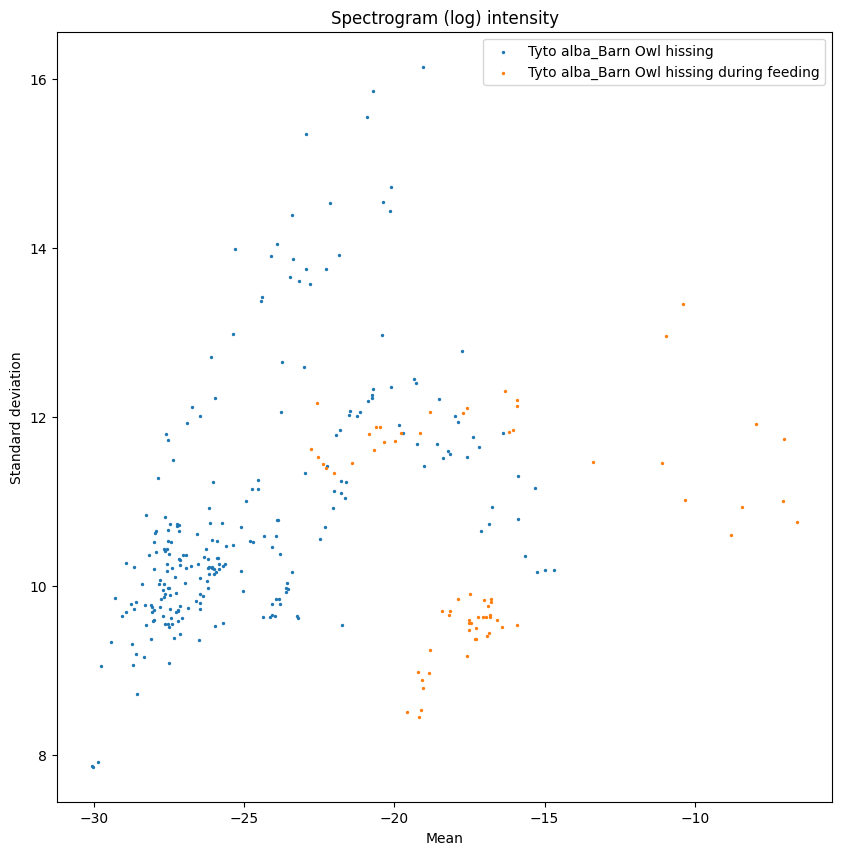

In [232]:
fig = plt.figure(figsize=(10,10))

for i_l, label in enumerate(labels):
    plt.scatter(test_intensities["mean"][test_classes == i_l], test_intensities["std"][test_classes == i_l], label=label, s=2)
plt.title("Spectrogram (log) intensity")
plt.xlabel("Mean")
plt.ylabel("Standard deviation")
plt.legend()
# plt.xlim([0,1])
# plt.ylim([0,2.5])
plt.show()

In [233]:
test_distances = []
n_neighbors = 20
for i, (f_i, seg) in enumerate(zip(test_audiofile_ids, test_segments)):
    this_file = test_audiofile_ids == f_i
    istart = np.argmax(this_file)
    iend = len(test_audiofile_ids) - np.argmax(this_file[::-1])
    neighbors_dist = [
        np.abs(test_segments[j].tstart - test_segments[j-1].tstart) 
        for j in range(max(istart + 1, i-n_neighbors), min(iend, i+n_neighbors))
    ]
    mean_distance = np.mean(neighbors_dist)
    test_distances.append(mean_distance)

test_distances = np.array(test_distances)

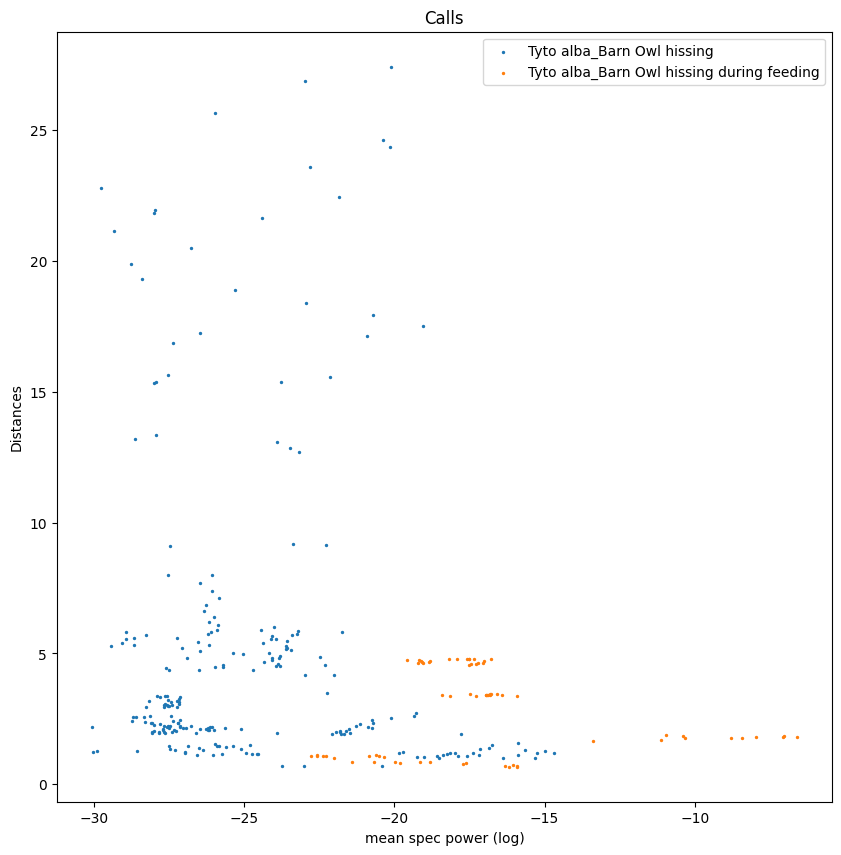

In [234]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
x = "mean"
for i_l, label in enumerate(labels):
    ax.scatter(test_intensities[x][test_classes == i_l], test_distances[test_classes == i_l], label=label, s=2)
plt.title("Calls")
plt.xlabel(f"{x} spec power (log)")
plt.ylabel("Distances")
plt.legend()
# plt.xlim([0,1])
# plt.ylim([0,2.5])
plt.show()

In [235]:
from joblib import  load

In [236]:

labels = list(test_intensities.keys())
test_X = np.stack([
    test_intensities["mean"],
    test_intensities["std"],
    test_distances
], axis=1)
test_y = test_classes

rf = load("..\\Documents\\rf.joblib")

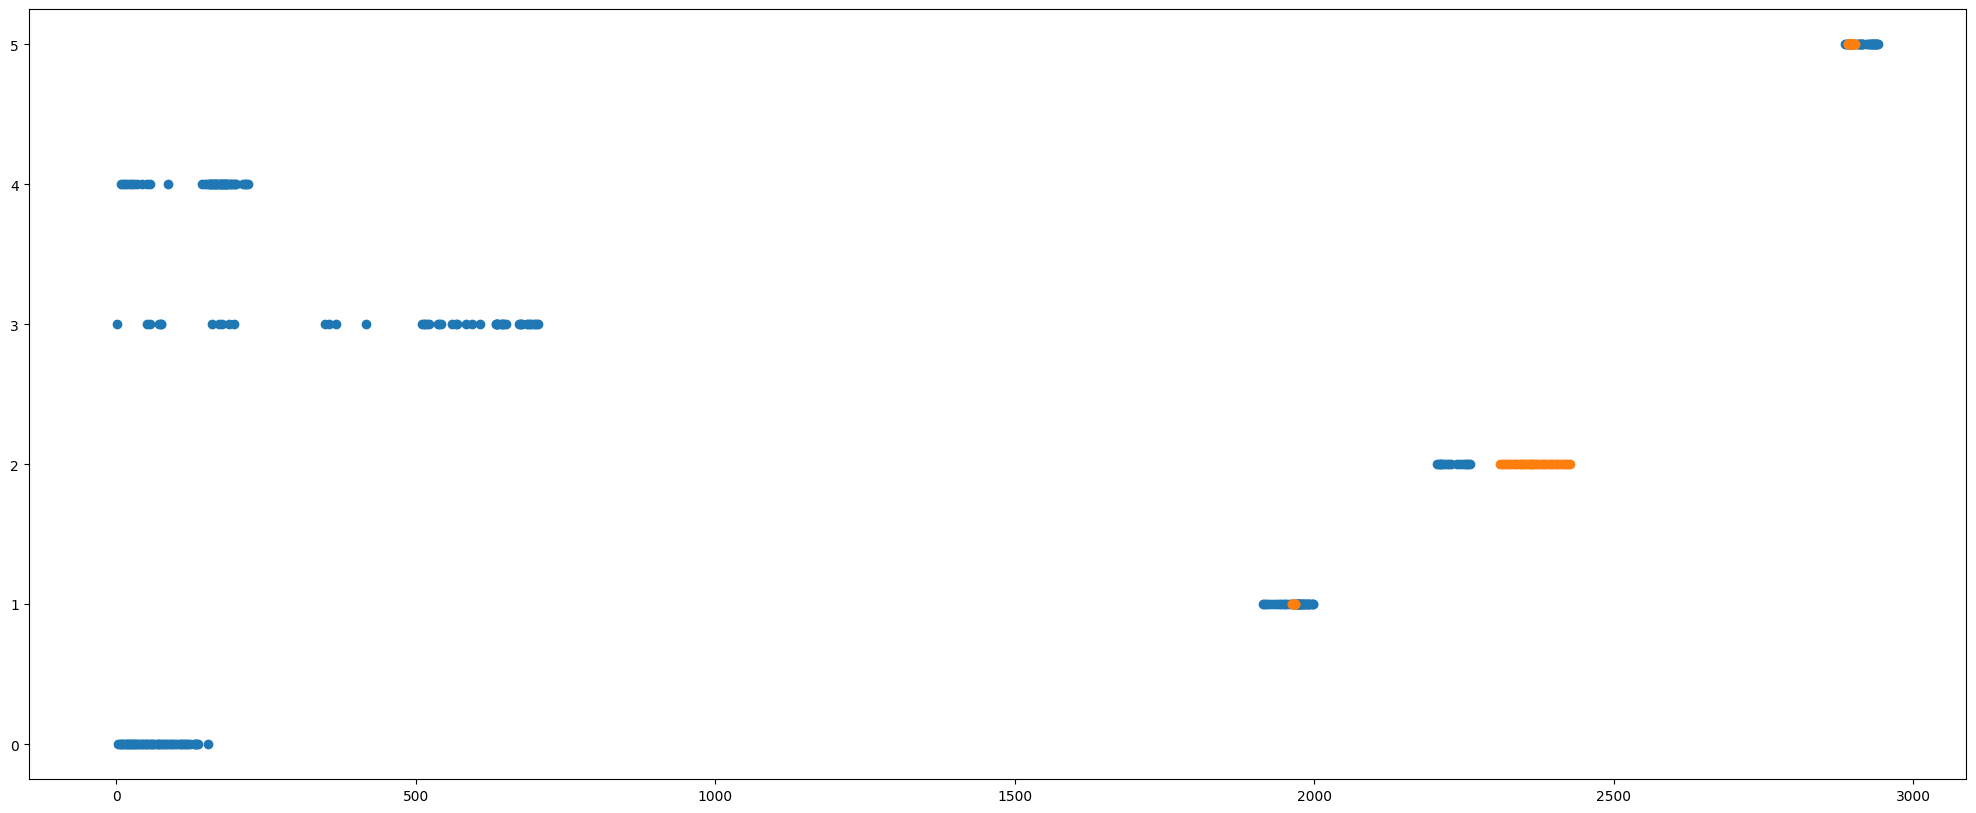

In [237]:
test_tstarts = np.array([s.tstart for s in test_segments])

colors_list = ["tab:blue", "tab:orange"]
fig = plt.figure(figsize=(25,10))


for i_l, label in enumerate(labels):
    plt.scatter(test_tstarts[test_classes == i_l], test_audiofile_ids[test_classes == i_l], c=colors_list[i_l], label=label)

plt.show()

0.8295819935691319
0.8102893890675241
0.7845659163987139


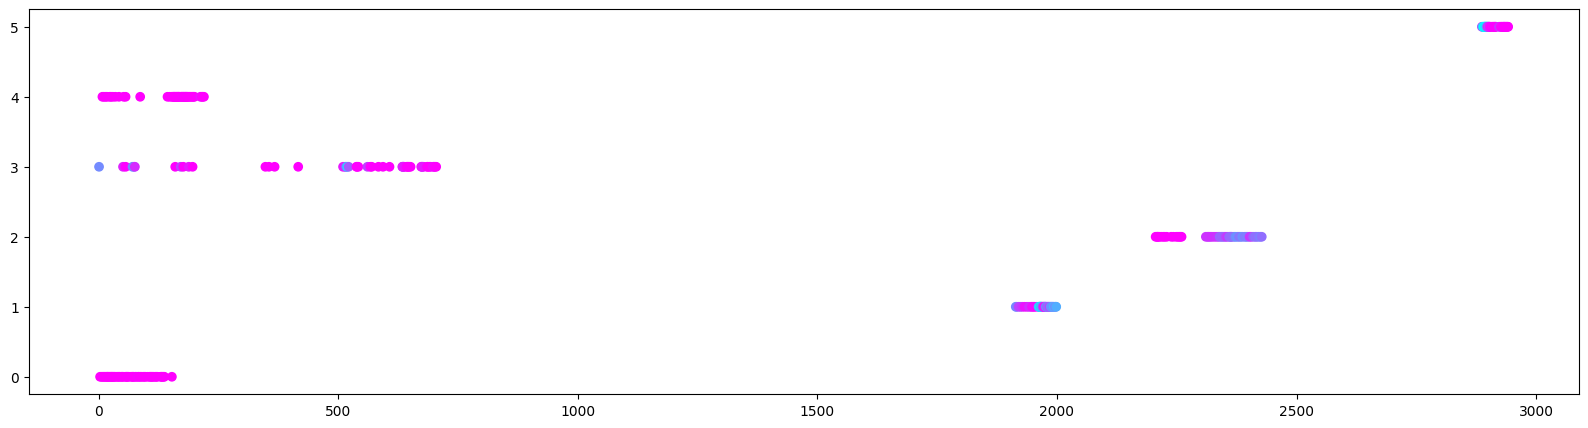

In [238]:
fig = plt.figure(figsize=(20,5))

test_y_pred_prob = rf.predict_proba(test_X)
test_y_pred = rf.predict(test_X)
print(mpl.score(test_X, test_classes))
print(rf.score(test_X, test_classes))
print(gnb.score(test_X, test_classes))
plt.scatter(test_tstarts, test_audiofile_ids, c=test_y_pred_prob[:,0], cmap="cool", label=label)

plt.show()